In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle

Revisa el formato porque el la columna de los canales esta en la columna de LG

Funcion de analisis de datos para calcular eficiencia

In [2]:
# funcion secundaria para discriminar eventos reales para activaciones triples y cudruples con adyacencia 
def conteo(cuadru, tripl, count, n_counts): # Dataframe, cuadruples, triples, lista de canales activados local, lista número de canales activados global, HG/LG, i-ésimo disparo
    
    n = len(count) # núm. canales activados
    #n_counts.append(n)
    
    # Discrimina rondas con cuadruples y que esten juntos cada pareja
    if n == 4:
        if count[0] == count[1] -1 and count[2] == count[3] - 1 and count[1]<=28 and count[2]>=32:
        
            # Parado desde cada canal, nota que él mismo, uno contiguo y otro 2 en el otro eje
            cuadru[count[0]] += 1
            cuadru[count[1]] += 1
            cuadru[count[2]] += 1
            cuadru[count[3]] += 1
            
            n_counts.append(n)
            
        #else:
            #error_count.append(count)
            
    # Discrimina rondas de triples
    elif n==3:
        # Discrimina si los canales están pegados en el eje X y el tercero pertenece al eje y
        if count[0] == count[1] - 1 and count[1] != count[2] - 1 and (count[1] <= 28 and count[2] >= 32):
            
            # Son triples aquellos contiguos al canal en y al no tener pareja
            # Condicionar para problema de bordes
            if count[2] > 32:
                tripl[count[2] -1] += 1
            if count[2] < 60:
                tripl[count[2] +1] += 1

            n_counts.append(n)
            
        # Discrimina si los canales están pegados en el eje Y y el primero pertenece al eje x
        elif count[0] != count[1] - 1 and count[1] == count[2] - 1 and (count[0] <= 28 and count[2] >= 32):
            
            # Son triples aquellos contiguos al canal en x al no tener pareja
            # Condicionar para problema de bordes
            if count[0] > 0:
                tripl[count[0] -1] += 1
            if count[0] < 28:
                tripl[count[0] +1] += 1
                
            n_counts.append(n)
        
        #else:
            #error_count.append(count)
    
    return cuadru, tripl, n_counts


def eficiencias(df, td_hg):
    
    # Diccionarios para 3-activaciones y 4-activaciones {canal:contador} para HG y LG
    triples_h = {}
    cuadruples_h = {}

    # Conteos totales por disparo {Núm.canales:contador}
    conteo_total_h = {}

    # Se llenan los disccionarios
    for i in range(64):
        triples_h[i]= 0
        cuadruples_h[i] = 0

        conteo_total_h[i] = 0
    
    # Tambien se pueden activar 64 canales
    conteo_total_h[64] = 0
    
    # Lista de cantidad de canales activados por disparo con HG y LG
    n_counts_h= [] 
    
    # Recorre cada ronda de activación - i-ésima ronda
    for i in tqdm(range(int(len(df)/64))):
        
        # Lista de los canales activos para aquellos discriminados en funcion de el HG, LG o b-ambos
        hg_count = []
        
        # Recorre todos los canales de la ronda de activación - j-ésimo canal de la i-ésimo disparo
        for j in range(64):
            
            # Valor del H/L gain
            hg = df["HG"].values[i*64 + j]

            # Discrimina y agrega el canal a la lista de canales activados
            if hg > td_hg:
                hg_count.append(j)
        
        # Agrega cantidad de canales activados en el disparo
        conteo_total_h[len(hg_count)] += 1
        
        conteo_total = [conteo_total_h]
        
        # Para cada tipo HG/LG/Both se determinará los conteos cuadruples y triples del i-ésimo disparo
        datos_h = conteo(cuadruples_h, triples_h, hg_count, n_counts_h) 
        
    #Corrección geométrica
    correc_exe = [1,27,33,59] #canales que corregir al considerar exceso de triples
    for i in correc_exe:
        datos_h[1][i] /= 2
        
    return datos_h, conteo_total

Cargar info en la función para ambas tomas

In [3]:
df_con = pd.read_parquet("data/Toma_datos_lider_15h.parquet", engine='pyarrow')
#df1 = df1.drop(['Brd', 'LG'], axis=1)

df_sin = pd.read_parquet("data/Toma_datos_subdito_15h.parquet", engine='pyarrow')
df_sin.rename(columns={'Ch': 'LG', 'LG':'Ch',}, inplace=True)

In [14]:
td_hg, td_lg = 1000, 150

datos_h_con, conteo_total_con = eficiencias(df_con, td_hg)
cuadruples_h_con, triples_h_con, n_counts_h_con = datos_h_con
conteo_total_h_con = conteo_total_con


datos_h_sin, conteo_total_sin = eficiencias(df_sin, td_hg)
cuadruples_h_sin, triples_h_sin, n_counts_h_sin = datos_h_sin
conteo_total_h_sin = conteo_total_sin

  0%|          | 0/1905687 [00:00<?, ?it/s]

100%|██████████| 1905689/1905689 [04:44<00:00, 6693.93it/s]


Calculo de eficiencia y error

In [15]:
cuadri_h_con = np.array(list(cuadruples_h_con.values()))
triple_h_con = np.array(list(triples_h_con.values()))

cuadri_h_sin = np.array(list(cuadruples_h_sin.values()))
triple_h_sin = np.array(list(triples_h_sin.values()))

canales = list(triples_h_con.keys())
canales2 = list(triples_h_sin.keys())

with np.errstate(divide='ignore', invalid='ignore'):
    efi_h_con = cuadri_h_con/(triple_h_con+cuadri_h_con)
    efi_h_sin = cuadri_h_sin/(triple_h_sin+cuadri_h_sin)

    err_efi_h_con = np.sqrt(cuadri_h_con*((triple_h_con/(cuadri_h_con+triple_h_con)**2))**2 + triple_h_con*((cuadri_h_con/(cuadri_h_con+triple_h_con)**2))**2)
    err_efi_h_sin = np.sqrt(cuadri_h_sin*((triple_h_sin/(cuadri_h_sin+triple_h_sin)**2))**2 + triple_h_sin*((cuadri_h_sin/(cuadri_h_sin+triple_h_sin)**2))**2)


In [18]:
new_efi_h_con = efi_h_con[~np.isnan(efi_h_con)]
new_efi_h_sin = efi_h_sin[~np.isnan(efi_h_sin)]
std_efi_h_con = np.std(new_efi_h_con)
std_efi_h_sin = np.std(new_efi_h_sin)
mean_efi_f_con = np.mean(new_efi_h_con)
mean_efi_f_sin = np.mean(new_efi_h_sin)


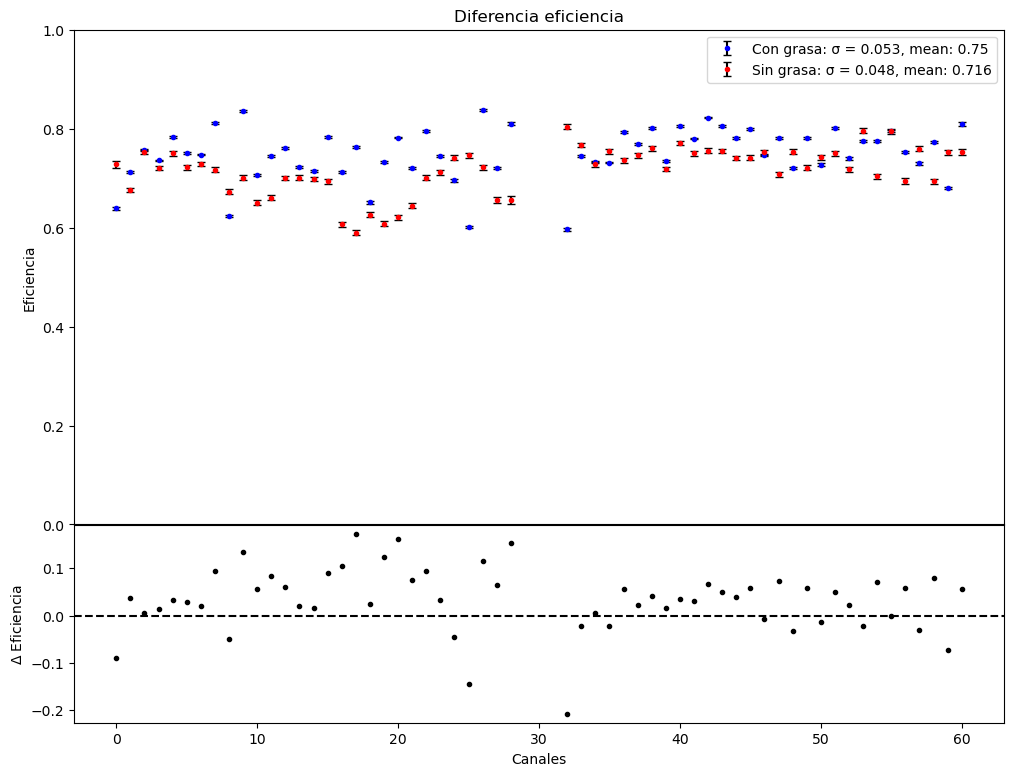

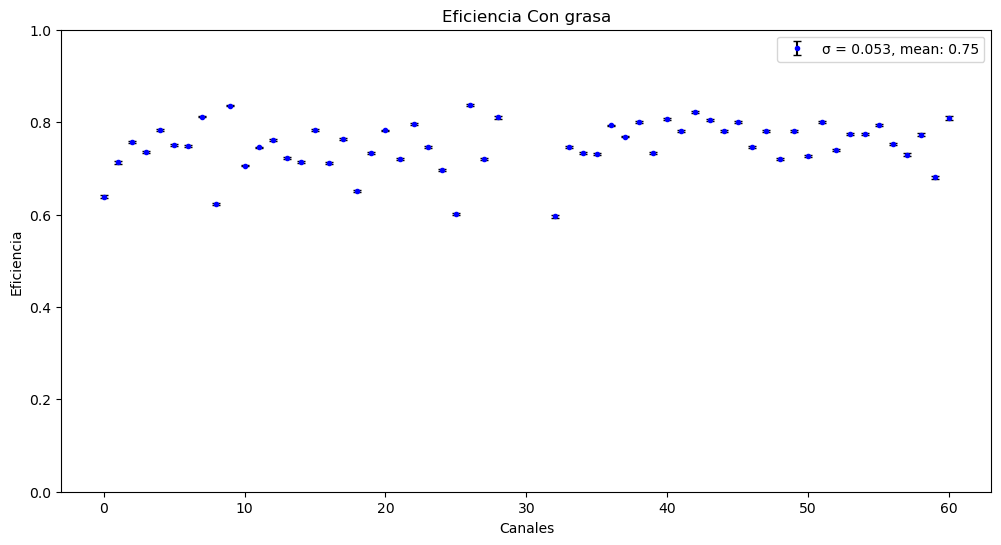

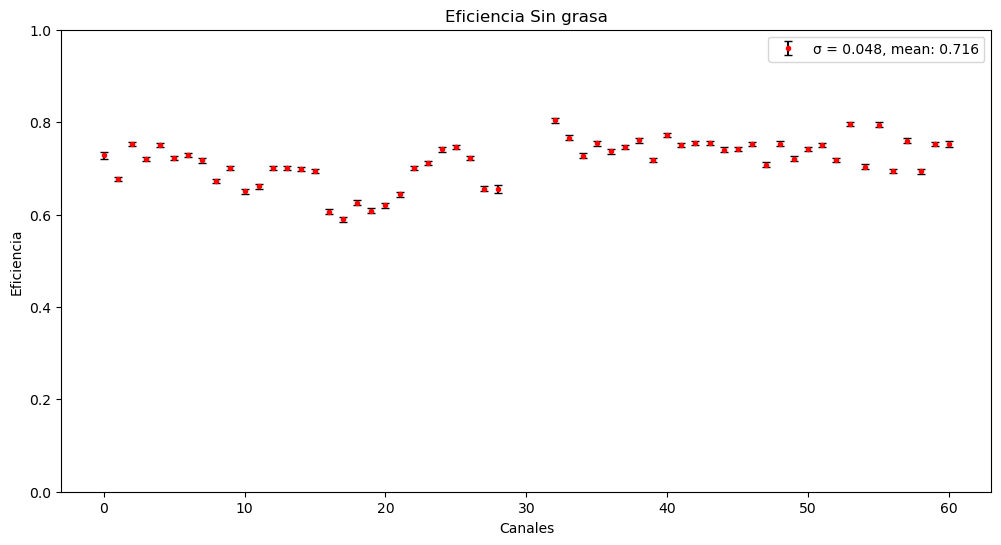

In [19]:
fig1, ax1 = plt.subplots(
    2, 1, 
    figsize=(12, 9), 
    height_ratios=[1, 0.4], 
    gridspec_kw={'hspace': 0.001})

#fig1, ax1 = plt.subplots(2, 1, figsize=(12, 9))
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))
fig3, ax3 = plt.subplots(1, 1, figsize=(12, 6))

ax1[0].errorbar(canales, efi_h_con, yerr=err_efi_h_con, fmt='.', color='blue', ecolor='black', capsize=3, label=f"Con grasa: σ = {round(std_efi_h_con,3)}, mean: {round(mean_efi_f_con,3)}")
ax1[0].errorbar(canales2, efi_h_sin, yerr=err_efi_h_sin, fmt='.', color='red', ecolor='black', capsize=3, label=f"Sin grasa: σ = {round(std_efi_h_sin,3)}, mean: {round(mean_efi_f_sin, 3)}")
ax1[0].set_title("Diferencia eficiencia")
ax1[0].set_ylabel("Eficiencia")
ax1[0].set_ylim(0,1)
ax1[0].legend()

ax1[1].scatter(canales2, efi_h_con-efi_h_sin, marker = ".",color='black')
ax1[1].axhline(y=0, color='black', linestyle='--')
ax1[1].set_xlabel("Canales")
ax1[1].set_ylabel(r"$\Delta$ Eficiencia")

ax2.errorbar(canales, efi_h_con, yerr=err_efi_h_con, fmt='.', color='blue', ecolor='black', capsize=3, label=f"σ = {round(std_efi_h_con,3)}, mean: {round(mean_efi_f_con,3)}")
ax2.set_title("Eficiencia Con grasa")
ax2.set_xlabel("Canales")
ax2.set_ylabel("Eficiencia")
ax2.set_ylim(0,1)
ax2.legend()

ax3.errorbar(canales, efi_h_sin, yerr=err_efi_h_sin, fmt='.', color='red', ecolor='black', capsize=3, label=f"σ = {round(std_efi_h_sin,3)}, mean: {round(mean_efi_f_sin, 3)}")
ax3.set_title("Eficiencia Sin grasa")
ax3.set_xlabel("Canales")
ax3.set_ylabel("Eficiencia")
ax3.set_ylim(0,1)
ax3.legend()

In [8]:
efi_h_sin

array([0.63887485, 0.70871472, 0.7541725 , 0.72738976, 0.778034  ,
       0.74561751, 0.74543666, 0.80510074, 0.61875989, 0.82531495,
       0.70252773, 0.74614489, 0.77010901, 0.72962984, 0.72110265,
       0.7809439 , 0.71202415, 0.74531546, 0.64159624, 0.72080642,
       0.77726415, 0.71852536, 0.79189806, 0.73726499, 0.69173963,
       0.58803031, 0.82995337, 0.71543344, 0.7947727 ,        nan,
              nan,        nan, 0.7654351 , 0.71792347, 0.77745879,
       0.72469341, 0.78468567, 0.76524024, 0.79721448, 0.72922725,
       0.80390495, 0.77671814, 0.81726257, 0.80226065, 0.77743277,
       0.78940274, 0.73984346, 0.77918949, 0.71232108, 0.77447306,
       0.72131448, 0.797627  , 0.73648463, 0.77249654, 0.76427927,
       0.79373515, 0.74293121, 0.72363541, 0.75982083, 0.67502123,
       0.78996159,        nan,        nan,        nan])